In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
############################################################
# 1. Импорт и основные настройки
############################################################
%pip install --upgrade diffusers transformers torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os

from diffusers import UNet2DModel, DDIMScheduler
from tqdm.auto import tqdm


############################################################
# 2. Настройка устройства
############################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Using device: cpu


In [ ]:
############################################################
# 3. Подготовка данных (FashionMNIST)
############################################################
transform = transforms.Compose([
    transforms.Resize(32),     # Увеличиваем до 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


100%|██████████| 26.4M/26.4M [00:02<00:00, 11.8MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 268kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.01MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.30MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Пример shape изображений: torch.Size([128, 1, 32, 32])
Пример меток: [1, 7, 3, 3, 6, 9, 4, 9]


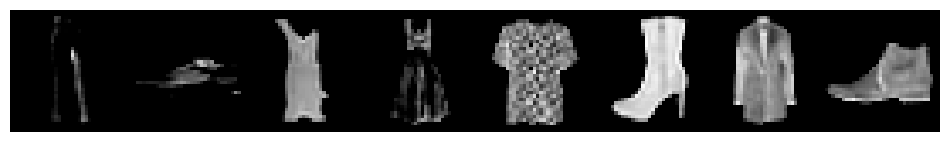

In [ ]:
# Для наглядности визуализируем один батч
batch_example, labels_example = next(iter(train_dataloader))
print("Пример shape изображений:", batch_example.shape)
print("Пример меток:", labels_example[:8].tolist())


grid_img = torchvision.utils.make_grid(batch_example[:8], nrow=8)
plt.figure(figsize=(12, 2))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
plt.axis("off")
plt.show()


In [ ]:
###########################################################
# 4. Эмбеддинг классов (manual)
############################################################
# У нас 10 классов (0..9). Добавим "пустой класс" (10) для unconditional pass.
num_classes = 10
num_total_classes = num_classes + 1  # +1 для пустого класса
embedding_dim = 8                   # На выходе будет 8 каналов под класс

class ClassEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        # Инициализация эмбеддингов (можно на ваше усмотрение)
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)

    def forward(self, labels: torch.LongTensor):
        """
        labels shape: (batch,)
        Returns: Tensor shape (batch, embedding_dim, 32, 32)
        """
        # (batch, embedding_dim)
        emb = self.embedding(labels)
        # Превращаем в (batch, embedding_dim, 1, 1)
        emb = emb.unsqueeze(-1).unsqueeze(-1)
        # Расширяем до (batch, embedding_dim, 32, 32)
        emb_2d = emb.expand(-1, -1, 32, 32)
        return emb_2d

class_embedder = ClassEmbedding(num_total_classes, embedding_dim).to(device)

In [ ]:
############################################################
# 5. Определение UNet2DModel
############################################################
# Входных каналов будет 1 (само изображение) + embedding_dim (8)
# Выход 1 канал (ч/б изображение).
model = UNet2DModel(
    sample_size=32,             # 32x32 вход
    in_channels=1 + embedding_dim,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(32, 64, 128),
    down_block_types=(
        "DownBlock2D",      # 1-й блок, обычный
        "DownBlock2D",      # 2-й блок, обычный
        "AttnDownBlock2D",  # 3-й блок, с self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",    # можно поставить attention в самом "центре"
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device)


print("Model created. in_channels:", model.config.in_channels)


Model created. in_channels: 9


In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Количество обучаемых параметров в модели: {num_params}")

Количество обучаемых параметров в модели: 3941697


In [ ]:
############################################################
# 6. Настройка scheduler (DDIM)
############################################################
scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
    beta_schedule="linear"
)# Например, 50 шагов вывода

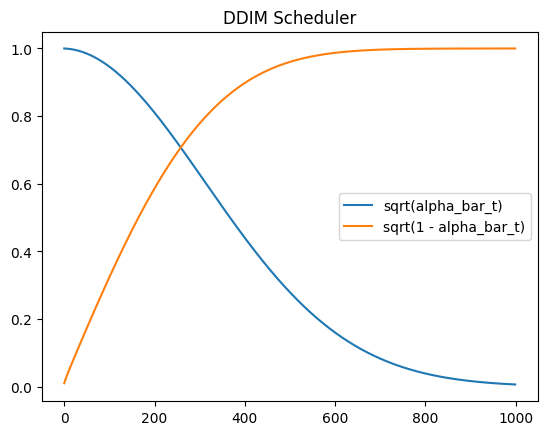

In [ ]:
plt.plot(scheduler.alphas_cumprod.cpu()**0.5, label="sqrt(alpha_bar_t)")
plt.plot((1 - scheduler.alphas_cumprod.cpu())**0.5, label="sqrt(1 - alpha_bar_t)")
plt.legend()
plt.title("DDIM Scheduler")
plt.show()

In [ ]:
############################################################
# 7. Функция обучения
############################################################
# Параметры обучения
p_drop = 0.05       # Вероятность заменять реальный класс на "пустой"
num_epochs = 100
lr = 3e-4
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
mse = nn.MSELoss()

def train_step(images, labels):
    """
    Один шаг обучения:
    1) Сгенерировать случайные timesteps
    2) Смешать изображения с шумом
    3) Предсказать шум и сравнить с реальным
    """
    # С вероятностью p_drop заменяем класс на "пустой" (индекс = 10)
    mask = (torch.rand(labels.shape, device=device) > p_drop)
    labels_cond = labels.clone()
    labels_cond[~mask] = num_classes  # 10 = пустой класс

    # Генерация случайных временных шагов
    timesteps = torch.randint(
        low=0,
        high=scheduler.config.num_train_timesteps,
        size=(images.shape[0],),
        device=device
    ).long()

    # Сгенерировать шум
    noise = torch.randn_like(images)
    # Добавить шум к изображению
    noisy_images = scheduler.add_noise(images, noise, timesteps)

    # Получить эмбеддинг класса (B, emb_dim, 32, 32)
    c_emb = class_embedder(labels_cond)
    # Конкатенировать по оси каналов => (B, 1+emb_dim, 32, 32)
    model_input = torch.cat([noisy_images, c_emb], dim=1)

    # Прогон через модель
    noise_pred = model(model_input, timesteps).sample  # (B, 1, 32, 32)

    # Считаем MSE
    loss = mse(noise_pred, noise)
    return loss

In [ ]:
############################################################
# 8. Обучающий цикл
############################################################
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(tqdm(train_dataloader)):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        loss = train_step(images, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        losses.append(loss.item())

        if batch_idx % 100 == 0:
            print(f"Epoch[{epoch+1}/{num_epochs}] Batch[{batch_idx}] Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_dataloader)
    print(f"Epoch[{epoch+1}/{num_epochs}] >>> Average Loss: {avg_loss:.4f}")



  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[1/100] Batch[0] Loss: 1.1759
Epoch[1/100] Batch[100] Loss: 0.0615
Epoch[1/100] Batch[200] Loss: 0.0547
Epoch[1/100] Batch[300] Loss: 0.0522
Epoch[1/100] Batch[400] Loss: 0.0381
Epoch[1/100] >>> Average Loss: 0.0713


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[2/100] Batch[0] Loss: 0.0476
Epoch[2/100] Batch[100] Loss: 0.0345
Epoch[2/100] Batch[200] Loss: 0.0283
Epoch[2/100] Batch[300] Loss: 0.0392
Epoch[2/100] Batch[400] Loss: 0.0304
Epoch[2/100] >>> Average Loss: 0.0375


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[3/100] Batch[0] Loss: 0.0389
Epoch[3/100] Batch[100] Loss: 0.0318
Epoch[3/100] Batch[200] Loss: 0.0356
Epoch[3/100] Batch[300] Loss: 0.0326
Epoch[3/100] Batch[400] Loss: 0.0325
Epoch[3/100] >>> Average Loss: 0.0343


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[4/100] Batch[0] Loss: 0.0274
Epoch[4/100] Batch[100] Loss: 0.0253
Epoch[4/100] Batch[200] Loss: 0.0400
Epoch[4/100] Batch[300] Loss: 0.0337
Epoch[4/100] Batch[400] Loss: 0.0257
Epoch[4/100] >>> Average Loss: 0.0320


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[5/100] Batch[0] Loss: 0.0238
Epoch[5/100] Batch[100] Loss: 0.0393
Epoch[5/100] Batch[200] Loss: 0.0409
Epoch[5/100] Batch[300] Loss: 0.0219
Epoch[5/100] Batch[400] Loss: 0.0309
Epoch[5/100] >>> Average Loss: 0.0310


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[6/100] Batch[0] Loss: 0.0357
Epoch[6/100] Batch[100] Loss: 0.0351
Epoch[6/100] Batch[200] Loss: 0.0298
Epoch[6/100] Batch[300] Loss: 0.0234
Epoch[6/100] Batch[400] Loss: 0.0274
Epoch[6/100] >>> Average Loss: 0.0295


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[7/100] Batch[0] Loss: 0.0256
Epoch[7/100] Batch[100] Loss: 0.0307
Epoch[7/100] Batch[200] Loss: 0.0253
Epoch[7/100] Batch[300] Loss: 0.0240
Epoch[7/100] Batch[400] Loss: 0.0275
Epoch[7/100] >>> Average Loss: 0.0294


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[8/100] Batch[0] Loss: 0.0367
Epoch[8/100] Batch[100] Loss: 0.0292
Epoch[8/100] Batch[200] Loss: 0.0274
Epoch[8/100] Batch[300] Loss: 0.0254
Epoch[8/100] Batch[400] Loss: 0.0305
Epoch[8/100] >>> Average Loss: 0.0288


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[9/100] Batch[0] Loss: 0.0220
Epoch[9/100] Batch[100] Loss: 0.0249
Epoch[9/100] Batch[200] Loss: 0.0188
Epoch[9/100] Batch[300] Loss: 0.0332
Epoch[9/100] Batch[400] Loss: 0.0296
Epoch[9/100] >>> Average Loss: 0.0282


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[10/100] Batch[0] Loss: 0.0159
Epoch[10/100] Batch[100] Loss: 0.0265
Epoch[10/100] Batch[200] Loss: 0.0268
Epoch[10/100] Batch[300] Loss: 0.0256
Epoch[10/100] Batch[400] Loss: 0.0282
Epoch[10/100] >>> Average Loss: 0.0276


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[11/100] Batch[0] Loss: 0.0273
Epoch[11/100] Batch[100] Loss: 0.0201
Epoch[11/100] Batch[200] Loss: 0.0212
Epoch[11/100] Batch[300] Loss: 0.0276
Epoch[11/100] Batch[400] Loss: 0.0254
Epoch[11/100] >>> Average Loss: 0.0273


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[12/100] Batch[0] Loss: 0.0385
Epoch[12/100] Batch[100] Loss: 0.0305
Epoch[12/100] Batch[200] Loss: 0.0182
Epoch[12/100] Batch[300] Loss: 0.0340
Epoch[12/100] Batch[400] Loss: 0.0304
Epoch[12/100] >>> Average Loss: 0.0269


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[13/100] Batch[0] Loss: 0.0284
Epoch[13/100] Batch[100] Loss: 0.0220
Epoch[13/100] Batch[200] Loss: 0.0314
Epoch[13/100] Batch[300] Loss: 0.0237
Epoch[13/100] Batch[400] Loss: 0.0351
Epoch[13/100] >>> Average Loss: 0.0268


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[14/100] Batch[0] Loss: 0.0254
Epoch[14/100] Batch[100] Loss: 0.0291
Epoch[14/100] Batch[200] Loss: 0.0268
Epoch[14/100] Batch[300] Loss: 0.0290
Epoch[14/100] Batch[400] Loss: 0.0295
Epoch[14/100] >>> Average Loss: 0.0267


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: 

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>Traceback (most recent call last):
AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
: Traceback (most recent call last):
can only test a child process      File "/usr/local/lib/python3.10/dist-packages/torc

Epoch[15/100] Batch[0] Loss: 0.0211
Epoch[15/100] Batch[100] Loss: 0.0264
Epoch[15/100] Batch[200] Loss: 0.0245
Epoch[15/100] Batch[300] Loss: 0.0322
Epoch[15/100] Batch[400] Loss: 0.0293
Epoch[15/100] >>> Average Loss: 0.0268


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[16/100] Batch[0] Loss: 0.0292
Epoch[16/100] Batch[100] Loss: 0.0293
Epoch[16/100] Batch[200] Loss: 0.0272
Epoch[16/100] Batch[300] Loss: 0.0379
Epoch[16/100] Batch[400] Loss: 0.0321
Epoch[16/100] >>> Average Loss: 0.0264


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[17/100] Batch[0] Loss: 0.0265
Epoch[17/100] Batch[100] Loss: 0.0257
Epoch[17/100] Batch[200] Loss: 0.0298
Epoch[17/100] Batch[300] Loss: 0.0213
Epoch[17/100] Batch[400] Loss: 0.0216
Epoch[17/100] >>> Average Loss: 0.0263


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[18/100] Batch[0] Loss: 0.0272
Epoch[18/100] Batch[100] Loss: 0.0204
Epoch[18/100] Batch[200] Loss: 0.0254
Epoch[18/100] Batch[300] Loss: 0.0313
Epoch[18/100] Batch[400] Loss: 0.0215
Epoch[18/100] >>> Average Loss: 0.0264


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[19/100] Batch[0] Loss: 0.0339
Epoch[19/100] Batch[100] Loss: 0.0381
Epoch[19/100] Batch[200] Loss: 0.0309
Epoch[19/100] Batch[300] Loss: 0.0233
Epoch[19/100] Batch[400] Loss: 0.0270
Epoch[19/100] >>> Average Loss: 0.0258


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: AssertionError<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>: 
can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[20/100] Batch[0] Loss: 0.0270
Epoch[20/100] Batch[100] Loss: 0.0281
Epoch[20/100] Batch[200] Loss: 0.0215
Epoch[20/100] Batch[300] Loss: 0.0248
Epoch[20/100] Batch[400] Loss: 0.0311
Epoch[20/100] >>> Average Loss: 0.0260


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[21/100] Batch[0] Loss: 0.0178
Epoch[21/100] Batch[100] Loss: 0.0277
Epoch[21/100] Batch[200] Loss: 0.0300
Epoch[21/100] Batch[300] Loss: 0.0215
Epoch[21/100] Batch[400] Loss: 0.0275
Epoch[21/100] >>> Average Loss: 0.0255


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[22/100] Batch[0] Loss: 0.0335
Epoch[22/100] Batch[100] Loss: 0.0343
Epoch[22/100] Batch[200] Loss: 0.0349
Epoch[22/100] Batch[300] Loss: 0.0263
Epoch[22/100] Batch[400] Loss: 0.0192
Epoch[22/100] >>> Average Loss: 0.0255


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[23/100] Batch[0] Loss: 0.0264
Epoch[23/100] Batch[100] Loss: 0.0267
Epoch[23/100] Batch[200] Loss: 0.0222
Epoch[23/100] Batch[300] Loss: 0.0213
Epoch[23/100] Batch[400] Loss: 0.0330
Epoch[23/100] >>> Average Loss: 0.0253


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[24/100] Batch[0] Loss: 0.0317
Epoch[24/100] Batch[100] Loss: 0.0294
Epoch[24/100] Batch[200] Loss: 0.0235
Epoch[24/100] Batch[300] Loss: 0.0305
Epoch[24/100] Batch[400] Loss: 0.0197
Epoch[24/100] >>> Average Loss: 0.0255


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Epoch[25/100] Batch[0] Loss: 0.0223
Epoch[25/100] Batch[100] Loss: 0.0193
Epoch[25/100] Batch[200] Loss: 0.0256
Epoch[25/100] Batch[300] Loss: 0.0275
Epoch[25/100] Batch[400] Loss: 0.0224
Epoch[25/100] >>> Average Loss: 0.0254


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[26/100] Batch[0] Loss: 0.0228
Epoch[26/100] Batch[100] Loss: 0.0233
Epoch[26/100] Batch[200] Loss: 0.0186
Epoch[26/100] Batch[300] Loss: 0.0250
Epoch[26/100] Batch[400] Loss: 0.0213
Epoch[26/100] >>> Average Loss: 0.0252


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[27/100] Batch[0] Loss: 0.0299
Epoch[27/100] Batch[100] Loss: 0.0210
Epoch[27/100] Batch[200] Loss: 0.0254
Epoch[27/100] Batch[300] Loss: 0.0368
Epoch[27/100] Batch[400] Loss: 0.0200
Epoch[27/100] >>> Average Loss: 0.0254


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[28/100] Batch[0] Loss: 0.0314
Epoch[28/100] Batch[100] Loss: 0.0336
Epoch[28/100] Batch[200] Loss: 0.0198
Epoch[28/100] Batch[300] Loss: 0.0250
Epoch[28/100] Batch[400] Loss: 0.0226
Epoch[28/100] >>> Average Loss: 0.0248


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[29/100] Batch[0] Loss: 0.0232
Epoch[29/100] Batch[100] Loss: 0.0341
Epoch[29/100] Batch[200] Loss: 0.0236
Epoch[29/100] Batch[300] Loss: 0.0246
Epoch[29/100] Batch[400] Loss: 0.0281
Epoch[29/100] >>> Average Loss: 0.0247


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File "/usr/lib/python3.10/multiprocessing/proce

Epoch[30/100] Batch[0] Loss: 0.0243
Epoch[30/100] Batch[100] Loss: 0.0207
Epoch[30/100] Batch[200] Loss: 0.0329
Epoch[30/100] Batch[300] Loss: 0.0236
Epoch[30/100] Batch[400] Loss: 0.0277
Epoch[30/100] >>> Average Loss: 0.0250


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[31/100] Batch[0] Loss: 0.0249
Epoch[31/100] Batch[100] Loss: 0.0201
Epoch[31/100] Batch[200] Loss: 0.0190
Epoch[31/100] Batch[300] Loss: 0.0203
Epoch[31/100] Batch[400] Loss: 0.0291
Epoch[31/100] >>> Average Loss: 0.0249


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[32/100] Batch[0] Loss: 0.0277
Epoch[32/100] Batch[100] Loss: 0.0290
Epoch[32/100] Batch[200] Loss: 0.0219
Epoch[32/100] Batch[300] Loss: 0.0305
Epoch[32/100] Batch[400] Loss: 0.0355
Epoch[32/100] >>> Average Loss: 0.0249


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[33/100] Batch[0] Loss: 0.0280
Epoch[33/100] Batch[100] Loss: 0.0179
Epoch[33/100] Batch[200] Loss: 0.0239
Epoch[33/100] Batch[300] Loss: 0.0259
Epoch[33/100] Batch[400] Loss: 0.0187
Epoch[33/100] >>> Average Loss: 0.0251


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in: Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>if w.is_alive():Traceback (most recent call last):


  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
          File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child pro

Epoch[34/100] Batch[0] Loss: 0.0228
Epoch[34/100] Batch[100] Loss: 0.0322
Epoch[34/100] Batch[200] Loss: 0.0203
Epoch[34/100] Batch[300] Loss: 0.0198
Epoch[34/100] Batch[400] Loss: 0.0238
Epoch[34/100] >>> Average Loss: 0.0251


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[35/100] Batch[0] Loss: 0.0225
Epoch[35/100] Batch[100] Loss: 0.0238
Epoch[35/100] Batch[200] Loss: 0.0218
Epoch[35/100] Batch[300] Loss: 0.0240
Epoch[35/100] Batch[400] Loss: 0.0218
Epoch[35/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[36/100] Batch[0] Loss: 0.0231
Epoch[36/100] Batch[100] Loss: 0.0253
Epoch[36/100] Batch[200] Loss: 0.0235
Epoch[36/100] Batch[300] Loss: 0.0212
Epoch[36/100] Batch[400] Loss: 0.0222
Epoch[36/100] >>> Average Loss: 0.0243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[37/100] Batch[0] Loss: 0.0290
Epoch[37/100] Batch[100] Loss: 0.0270
Epoch[37/100] Batch[200] Loss: 0.0205
Epoch[37/100] Batch[300] Loss: 0.0214
Epoch[37/100] Batch[400] Loss: 0.0249
Epoch[37/100] >>> Average Loss: 0.0246


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
        if w.is_alive():if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        Exception ignored in: assert self._parent_pid == os.

Epoch[38/100] Batch[0] Loss: 0.0275
Epoch[38/100] Batch[100] Loss: 0.0282
Epoch[38/100] Batch[200] Loss: 0.0295
Epoch[38/100] Batch[300] Loss: 0.0283
Epoch[38/100] Batch[400] Loss: 0.0331
Epoch[38/100] >>> Average Loss: 0.0247


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[39/100] Batch[0] Loss: 0.0261
Epoch[39/100] Batch[100] Loss: 0.0291
Epoch[39/100] Batch[200] Loss: 0.0247
Epoch[39/100] Batch[300] Loss: 0.0278
Epoch[39/100] Batch[400] Loss: 0.0245
Epoch[39/100] >>> Average Loss: 0.0247


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[40/100] Batch[0] Loss: 0.0260
Epoch[40/100] Batch[100] Loss: 0.0302
Epoch[40/100] Batch[200] Loss: 0.0198
Epoch[40/100] Batch[300] Loss: 0.0235
Epoch[40/100] Batch[400] Loss: 0.0325
Epoch[40/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[41/100] Batch[0] Loss: 0.0188
Epoch[41/100] Batch[100] Loss: 0.0280
Epoch[41/100] Batch[200] Loss: 0.0241
Epoch[41/100] Batch[300] Loss: 0.0223
Epoch[41/100] Batch[400] Loss: 0.0248
Epoch[41/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[42/100] Batch[0] Loss: 0.0231
Epoch[42/100] Batch[100] Loss: 0.0268
Epoch[42/100] Batch[200] Loss: 0.0338
Epoch[42/100] Batch[300] Loss: 0.0387
Epoch[42/100] Batch[400] Loss: 0.0233
Epoch[42/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[43/100] Batch[0] Loss: 0.0144
Epoch[43/100] Batch[100] Loss: 0.0289
Epoch[43/100] Batch[200] Loss: 0.0294
Epoch[43/100] Batch[300] Loss: 0.0241
Epoch[43/100] Batch[400] Loss: 0.0308
Epoch[43/100] >>> Average Loss: 0.0244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[44/100] Batch[0] Loss: 0.0192
Epoch[44/100] Batch[100] Loss: 0.0245
Epoch[44/100] Batch[200] Loss: 0.0190
Epoch[44/100] Batch[300] Loss: 0.0269
Epoch[44/100] Batch[400] Loss: 0.0299
Epoch[44/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[45/100] Batch[0] Loss: 0.0176
Epoch[45/100] Batch[100] Loss: 0.0313
Epoch[45/100] Batch[200] Loss: 0.0276
Epoch[45/100] Batch[300] Loss: 0.0256
Epoch[45/100] Batch[400] Loss: 0.0267
Epoch[45/100] >>> Average Loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[46/100] Batch[0] Loss: 0.0183
Epoch[46/100] Batch[100] Loss: 0.0251
Epoch[46/100] Batch[200] Loss: 0.0217
Epoch[46/100] Batch[300] Loss: 0.0249
Epoch[46/100] Batch[400] Loss: 0.0215
Epoch[46/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[47/100] Batch[0] Loss: 0.0210
Epoch[47/100] Batch[100] Loss: 0.0220
Epoch[47/100] Batch[200] Loss: 0.0217
Epoch[47/100] Batch[300] Loss: 0.0296
Epoch[47/100] Batch[400] Loss: 0.0182
Epoch[47/100] >>> Average Loss: 0.0244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[48/100] Batch[0] Loss: 0.0184
Epoch[48/100] Batch[100] Loss: 0.0222
Epoch[48/100] Batch[200] Loss: 0.0247
Epoch[48/100] Batch[300] Loss: 0.0193
Epoch[48/100] Batch[400] Loss: 0.0207
Epoch[48/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[49/100] Batch[0] Loss: 0.0257
Epoch[49/100] Batch[100] Loss: 0.0280
Epoch[49/100] Batch[200] Loss: 0.0337
Epoch[49/100] Batch[300] Loss: 0.0279
Epoch[49/100] Batch[400] Loss: 0.0247
Epoch[49/100] >>> Average Loss: 0.0242


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/469 [00:00<?, ?it/s]


AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
:     can only test a c

Epoch[50/100] Batch[0] Loss: 0.0174
Epoch[50/100] Batch[100] Loss: 0.0273
Epoch[50/100] Batch[200] Loss: 0.0207
Epoch[50/100] Batch[300] Loss: 0.0304
Epoch[50/100] Batch[400] Loss: 0.0179
Epoch[50/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[51/100] Batch[0] Loss: 0.0171
Epoch[51/100] Batch[100] Loss: 0.0219
Epoch[51/100] Batch[200] Loss: 0.0304
Epoch[51/100] Batch[300] Loss: 0.0362
Epoch[51/100] Batch[400] Loss: 0.0230
Epoch[51/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[52/100] Batch[0] Loss: 0.0290
Epoch[52/100] Batch[100] Loss: 0.0330
Epoch[52/100] Batch[200] Loss: 0.0286
Epoch[52/100] Batch[300] Loss: 0.0238
Epoch[52/100] Batch[400] Loss: 0.0168
Epoch[52/100] >>> Average Loss: 0.0243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[53/100] Batch[0] Loss: 0.0256
Epoch[53/100] Batch[100] Loss: 0.0208
Epoch[53/100] Batch[200] Loss: 0.0264
Epoch[53/100] Batch[300] Loss: 0.0210
Epoch[53/100] Batch[400] Loss: 0.0265
Epoch[53/100] >>> Average Loss: 0.0248


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>

AssertionErrorTraceback (most recent call last):
:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
can only test a child process    
self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Epoch[54/100] Batch[0] Loss: 0.0239
Epoch[54/100] Batch[100] Loss: 0.0179
Epoch[54/100] Batch[200] Loss: 0.0201
Epoch[54/100] Batch[300] Loss: 0.0392
Epoch[54/100] Batch[400] Loss: 0.0211
Epoch[54/100] >>> Average Loss: 0.0241


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[55/100] Batch[0] Loss: 0.0197
Epoch[55/100] Batch[100] Loss: 0.0220
Epoch[55/100] Batch[200] Loss: 0.0288
Epoch[55/100] Batch[300] Loss: 0.0210
Epoch[55/100] Batch[400] Loss: 0.0268
Epoch[55/100] >>> Average Loss: 0.0244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[56/100] Batch[0] Loss: 0.0276
Epoch[56/100] Batch[100] Loss: 0.0278
Epoch[56/100] Batch[200] Loss: 0.0360
Epoch[56/100] Batch[300] Loss: 0.0309
Epoch[56/100] Batch[400] Loss: 0.0191
Epoch[56/100] >>> Average Loss: 0.0241


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[57/100] Batch[0] Loss: 0.0253
Epoch[57/100] Batch[100] Loss: 0.0227
Epoch[57/100] Batch[200] Loss: 0.0306
Epoch[57/100] Batch[300] Loss: 0.0276
Epoch[57/100] Batch[400] Loss: 0.0249
Epoch[57/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch[58/100] Batch[0] Loss: 0.0264


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch[58/100] Batch[100] Loss: 0.0215
Epoch[58/100] Batch[200] Loss: 0.0251
Epoch[58/100] Batch[300] Loss: 0.0174
Epoch[58/100] Batch[400] Loss: 0.0172
Epoch[58/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[59/100] Batch[0] Loss: 0.0239
Epoch[59/100] Batch[100] Loss: 0.0302
Epoch[59/100] Batch[200] Loss: 0.0231
Epoch[59/100] Batch[300] Loss: 0.0193
Epoch[59/100] Batch[400] Loss: 0.0181
Epoch[59/100] >>> Average Loss: 0.0245


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[60/100] Batch[0] Loss: 0.0212
Epoch[60/100] Batch[100] Loss: 0.0208
Epoch[60/100] Batch[200] Loss: 0.0228
Epoch[60/100] Batch[300] Loss: 0.0216
Epoch[60/100] Batch[400] Loss: 0.0169
Epoch[60/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[61/100] Batch[0] Loss: 0.0142
Epoch[61/100] Batch[100] Loss: 0.0205
Epoch[61/100] Batch[200] Loss: 0.0145
Epoch[61/100] Batch[300] Loss: 0.0221
Epoch[61/100] Batch[400] Loss: 0.0197
Epoch[61/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[62/100] Batch[0] Loss: 0.0209
Epoch[62/100] Batch[100] Loss: 0.0228
Epoch[62/100] Batch[200] Loss: 0.0210
Epoch[62/100] Batch[300] Loss: 0.0305
Epoch[62/100] Batch[400] Loss: 0.0220
Epoch[62/100] >>> Average Loss: 0.0241


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[63/100] Batch[0] Loss: 0.0301
Epoch[63/100] Batch[100] Loss: 0.0270
Epoch[63/100] Batch[200] Loss: 0.0282
Epoch[63/100] Batch[300] Loss: 0.0300
Epoch[63/100] Batch[400] Loss: 0.0292
Epoch[63/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[64/100] Batch[0] Loss: 0.0241
Epoch[64/100] Batch[100] Loss: 0.0203
Epoch[64/100] Batch[200] Loss: 0.0188
Epoch[64/100] Batch[300] Loss: 0.0228
Epoch[64/100] Batch[400] Loss: 0.0182
Epoch[64/100] >>> Average Loss: 0.0243


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[65/100] Batch[0] Loss: 0.0248
Epoch[65/100] Batch[100] Loss: 0.0297
Epoch[65/100] Batch[200] Loss: 0.0230
Epoch[65/100] Batch[300] Loss: 0.0214
Epoch[65/100] Batch[400] Loss: 0.0225
Epoch[65/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():self._shutdown_workers()

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():AssertionError
:   File "/usr/lib/python3.10/multiprocessing/pro

Epoch[66/100] Batch[0] Loss: 0.0269
Epoch[66/100] Batch[100] Loss: 0.0178
Epoch[66/100] Batch[200] Loss: 0.0200
Epoch[66/100] Batch[300] Loss: 0.0193
Epoch[66/100] Batch[400] Loss: 0.0193
Epoch[66/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[67/100] Batch[0] Loss: 0.0195
Epoch[67/100] Batch[100] Loss: 0.0219
Epoch[67/100] Batch[200] Loss: 0.0226
Epoch[67/100] Batch[300] Loss: 0.0179
Epoch[67/100] Batch[400] Loss: 0.0271
Epoch[67/100] >>> Average Loss: 0.0236


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[68/100] Batch[0] Loss: 0.0188
Epoch[68/100] Batch[100] Loss: 0.0192
Epoch[68/100] Batch[200] Loss: 0.0252
Epoch[68/100] Batch[300] Loss: 0.0349
Epoch[68/100] Batch[400] Loss: 0.0185
Epoch[68/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[69/100] Batch[0] Loss: 0.0234
Epoch[69/100] Batch[100] Loss: 0.0246
Epoch[69/100] Batch[200] Loss: 0.0218
Epoch[69/100] Batch[300] Loss: 0.0301
Epoch[69/100] Batch[400] Loss: 0.0276
Epoch[69/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20><function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    
    self._shutdown_workers()Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__


      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
self._shutdown_workers()    

Epoch[70/100] Batch[0] Loss: 0.0187
Epoch[70/100] Batch[100] Loss: 0.0303
Epoch[70/100] Batch[200] Loss: 0.0128
Epoch[70/100] Batch[300] Loss: 0.0319
Epoch[70/100] Batch[400] Loss: 0.0218
Epoch[70/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[71/100] Batch[0] Loss: 0.0268
Epoch[71/100] Batch[100] Loss: 0.0240
Epoch[71/100] Batch[200] Loss: 0.0196
Epoch[71/100] Batch[300] Loss: 0.0275
Epoch[71/100] Batch[400] Loss: 0.0195
Epoch[71/100] >>> Average Loss: 0.0244


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[72/100] Batch[0] Loss: 0.0298
Epoch[72/100] Batch[100] Loss: 0.0155
Epoch[72/100] Batch[200] Loss: 0.0240
Epoch[72/100] Batch[300] Loss: 0.0182
Epoch[72/100] Batch[400] Loss: 0.0243
Epoch[72/100] >>> Average Loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[73/100] Batch[0] Loss: 0.0250
Epoch[73/100] Batch[100] Loss: 0.0211
Epoch[73/100] Batch[200] Loss: 0.0243
Epoch[73/100] Batch[300] Loss: 0.0204
Epoch[73/100] Batch[400] Loss: 0.0189
Epoch[73/100] >>> Average Loss: 0.0240


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>AssertionError
: Traceback (most recent call last):
can only test a child process  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

  0%|          | 0/469 [00:00<?, ?it/s]

can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch[74/100] Batch[0] Loss: 0.0200
Epoch[74/100] Batch[100] Loss: 0.0253
Epoch[74/100] Batch[200] Loss: 0.0204
Epoch[74/100] Batch[300] Loss: 0.0247
Epoch[74/100] Batch[400] Loss: 0.0279
Epoch[74/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[75/100] Batch[0] Loss: 0.0230
Epoch[75/100] Batch[100] Loss: 0.0242
Epoch[75/100] Batch[200] Loss: 0.0210
Epoch[75/100] Batch[300] Loss: 0.0251
Epoch[75/100] Batch[400] Loss: 0.0213
Epoch[75/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[76/100] Batch[0] Loss: 0.0262
Epoch[76/100] Batch[100] Loss: 0.0388
Epoch[76/100] Batch[200] Loss: 0.0213
Epoch[76/100] Batch[300] Loss: 0.0207
Epoch[76/100] Batch[400] Loss: 0.0288
Epoch[76/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[77/100] Batch[0] Loss: 0.0187
Epoch[77/100] Batch[100] Loss: 0.0334
Epoch[77/100] Batch[200] Loss: 0.0251
Epoch[77/100] Batch[300] Loss: 0.0292
Epoch[77/100] Batch[400] Loss: 0.0291
Epoch[77/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'Exception ignored in: Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>AssertionError
: Traceback (most recent call last):
can only test a child process<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__

    self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/pyt

Epoch[78/100] Batch[0] Loss: 0.0166
Epoch[78/100] Batch[100] Loss: 0.0289
Epoch[78/100] Batch[200] Loss: 0.0173
Epoch[78/100] Batch[300] Loss: 0.0206
Epoch[78/100] Batch[400] Loss: 0.0265
Epoch[78/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[79/100] Batch[0] Loss: 0.0245
Epoch[79/100] Batch[100] Loss: 0.0287
Epoch[79/100] Batch[200] Loss: 0.0274
Epoch[79/100] Batch[300] Loss: 0.0279
Epoch[79/100] Batch[400] Loss: 0.0334
Epoch[79/100] >>> Average Loss: 0.0236


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[80/100] Batch[0] Loss: 0.0225
Epoch[80/100] Batch[100] Loss: 0.0293
Epoch[80/100] Batch[200] Loss: 0.0269
Epoch[80/100] Batch[300] Loss: 0.0192
Epoch[80/100] Batch[400] Loss: 0.0249
Epoch[80/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[81/100] Batch[0] Loss: 0.0200
Epoch[81/100] Batch[100] Loss: 0.0297
Epoch[81/100] Batch[200] Loss: 0.0272
Epoch[81/100] Batch[300] Loss: 0.0299
Epoch[81/100] Batch[400] Loss: 0.0270
Epoch[81/100] >>> Average Loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers

Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive():Exception ignored in: AssertionError
<function _MultiProcessingD

Epoch[82/100] Batch[0] Loss: 0.0297
Epoch[82/100] Batch[100] Loss: 0.0203
Epoch[82/100] Batch[200] Loss: 0.0195
Epoch[82/100] Batch[300] Loss: 0.0222
Epoch[82/100] Batch[400] Loss: 0.0223
Epoch[82/100] >>> Average Loss: 0.0242


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[83/100] Batch[0] Loss: 0.0257
Epoch[83/100] Batch[100] Loss: 0.0227
Epoch[83/100] Batch[200] Loss: 0.0206
Epoch[83/100] Batch[300] Loss: 0.0285
Epoch[83/100] Batch[400] Loss: 0.0277
Epoch[83/100] >>> Average Loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[84/100] Batch[0] Loss: 0.0227
Epoch[84/100] Batch[100] Loss: 0.0241
Epoch[84/100] Batch[200] Loss: 0.0296
Epoch[84/100] Batch[300] Loss: 0.0312
Epoch[84/100] Batch[400] Loss: 0.0292
Epoch[84/100] >>> Average Loss: 0.0236


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[85/100] Batch[0] Loss: 0.0251
Epoch[85/100] Batch[100] Loss: 0.0163
Epoch[85/100] Batch[200] Loss: 0.0199
Epoch[85/100] Batch[300] Loss: 0.0246
Epoch[85/100] Batch[400] Loss: 0.0265
Epoch[85/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[86/100] Batch[0] Loss: 0.0247


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[86/100] Batch[100] Loss: 0.0346
Epoch[86/100] Batch[200] Loss: 0.0283
Epoch[86/100] Batch[300] Loss: 0.0238
Epoch[86/100] Batch[400] Loss: 0.0266
Epoch[86/100] >>> Average Loss: 0.0239


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[87/100] Batch[0] Loss: 0.0247
Epoch[87/100] Batch[100] Loss: 0.0209
Epoch[87/100] Batch[200] Loss: 0.0346
Epoch[87/100] Batch[300] Loss: 0.0251
Epoch[87/100] Batch[400] Loss: 0.0253
Epoch[87/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[88/100] Batch[0] Loss: 0.0301
Epoch[88/100] Batch[100] Loss: 0.0231
Epoch[88/100] Batch[200] Loss: 0.0284
Epoch[88/100] Batch[300] Loss: 0.0227
Epoch[88/100] Batch[400] Loss: 0.0222
Epoch[88/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[89/100] Batch[0] Loss: 0.0247
Epoch[89/100] Batch[100] Loss: 0.0213
Epoch[89/100] Batch[200] Loss: 0.0290
Epoch[89/100] Batch[300] Loss: 0.0240
Epoch[89/100] Batch[400] Loss: 0.0284
Epoch[89/100] >>> Average Loss: 0.0240


Exception ignored in: 

  0%|          | 0/469 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()

AssertionError  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
: can only test a child process    
if w.is_alive():
  File "/usr/lib/python3.10/multiproces

Epoch[90/100] Batch[0] Loss: 0.0213
Epoch[90/100] Batch[100] Loss: 0.0238
Epoch[90/100] Batch[200] Loss: 0.0255
Epoch[90/100] Batch[300] Loss: 0.0280
Epoch[90/100] Batch[400] Loss: 0.0234
Epoch[90/100] >>> Average Loss: 0.0236


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[91/100] Batch[0] Loss: 0.0222
Epoch[91/100] Batch[100] Loss: 0.0275
Epoch[91/100] Batch[200] Loss: 0.0251
Epoch[91/100] Batch[300] Loss: 0.0230
Epoch[91/100] Batch[400] Loss: 0.0297
Epoch[91/100] >>> Average Loss: 0.0241


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[92/100] Batch[0] Loss: 0.0183
Epoch[92/100] Batch[100] Loss: 0.0226
Epoch[92/100] Batch[200] Loss: 0.0255
Epoch[92/100] Batch[300] Loss: 0.0224
Epoch[92/100] Batch[400] Loss: 0.0176
Epoch[92/100] >>> Average Loss: 0.0237


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[93/100] Batch[0] Loss: 0.0193
Epoch[93/100] Batch[100] Loss: 0.0194
Epoch[93/100] Batch[200] Loss: 0.0265
Epoch[93/100] Batch[300] Loss: 0.0221
Epoch[93/100] Batch[400] Loss: 0.0243
Epoch[93/100] >>> Average Loss: 0.0238


  0%|          | 0/469 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Epoch[94/100] Batch[0] Loss: 0.0222
Epoch[94/100] Batch[100] Loss: 0.0228
Epoch[94/100] Batch[200] Loss: 0.0207
Epoch[94/100] Batch[300] Loss: 0.0201
Epoch[94/100] Batch[400] Loss: 0.0230
Epoch[94/100] >>> Average Loss: 0.0238


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[95/100] Batch[0] Loss: 0.0276
Epoch[95/100] Batch[100] Loss: 0.0226
Epoch[95/100] Batch[200] Loss: 0.0206
Epoch[95/100] Batch[300] Loss: 0.0210
Epoch[95/100] Batch[400] Loss: 0.0205
Epoch[95/100] >>> Average Loss: 0.0238


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[96/100] Batch[0] Loss: 0.0231
Epoch[96/100] Batch[100] Loss: 0.0220
Epoch[96/100] Batch[200] Loss: 0.0203
Epoch[96/100] Batch[300] Loss: 0.0221
Epoch[96/100] Batch[400] Loss: 0.0345
Epoch[96/100] >>> Average Loss: 0.0240


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[97/100] Batch[0] Loss: 0.0279
Epoch[97/100] Batch[100] Loss: 0.0194
Epoch[97/100] Batch[200] Loss: 0.0193
Epoch[97/100] Batch[300] Loss: 0.0239
Epoch[97/100] Batch[400] Loss: 0.0166
Epoch[97/100] >>> Average Loss: 0.0237


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):


  0%|          | 0/469 [00:00<?, ?it/s]

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in:     self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x78a4c09f6c20>    if w.is_alive():

Traceback (most recent call last):
  File "/usr/lib/

Epoch[98/100] Batch[0] Loss: 0.0211
Epoch[98/100] Batch[100] Loss: 0.0279
Epoch[98/100] Batch[200] Loss: 0.0300
Epoch[98/100] Batch[300] Loss: 0.0239
Epoch[98/100] Batch[400] Loss: 0.0231
Epoch[98/100] >>> Average Loss: 0.0238


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[99/100] Batch[0] Loss: 0.0236
Epoch[99/100] Batch[100] Loss: 0.0289
Epoch[99/100] Batch[200] Loss: 0.0229
Epoch[99/100] Batch[300] Loss: 0.0230
Epoch[99/100] Batch[400] Loss: 0.0188
Epoch[99/100] >>> Average Loss: 0.0238


  0%|          | 0/469 [00:00<?, ?it/s]

Epoch[100/100] Batch[0] Loss: 0.0170
Epoch[100/100] Batch[100] Loss: 0.0226
Epoch[100/100] Batch[200] Loss: 0.0240
Epoch[100/100] Batch[300] Loss: 0.0161
Epoch[100/100] Batch[400] Loss: 0.0216
Epoch[100/100] >>> Average Loss: 0.0235


In [ ]:
save_path_model = "/content/drive/MyDrive/diffusers/ClassifierFreeGuidance/output/unet_weights2.pth"
save_path_embed = "/content/drive/MyDrive/diffusers/ClassifierFreeGuidance/output/embedder2.pth"

# Сохраняем
torch.save(model.state_dict(), save_path_model)
torch.save(class_embedder.state_dict(), save_path_embed)
print("Модель и эмбеддер успешно сохранены!")

Модель и эмбеддер успешно сохранены!


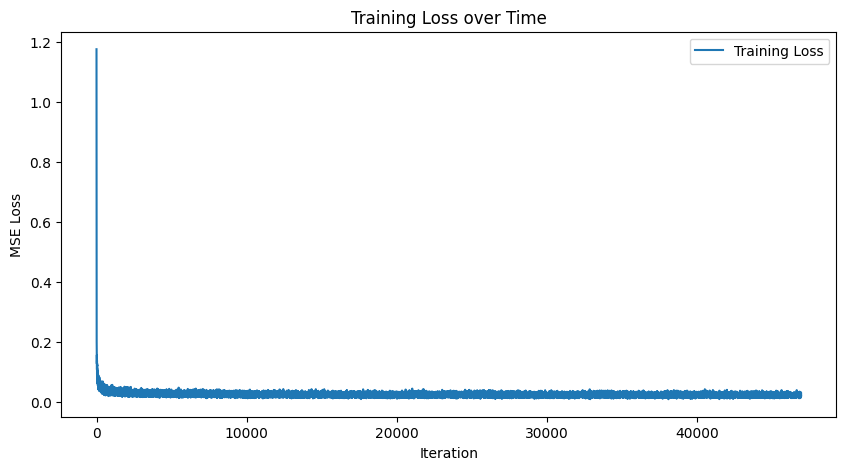

In [ ]:
# График потерь
plt.figure(figsize=(10,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Time')
plt.legend()
plt.show()

In [ ]:
############################################################
# 9. Функция генерации
############################################################

def generate_image(model, scheduler, class_label, guidance_scale=7.0, num_inference_steps=50):
    model.eval()

    sample_size = model.config.sample_size

    latents = torch.randn(
        (1, 1, sample_size, sample_size),
        device=device
    )

    scheduler.set_timesteps(num_inference_steps)


    scheduler.set_timesteps(num_inference_steps)

    # Подготавливаем классы: условный и безусловный
    cond = torch.tensor([class_label], device=device)
    uncond = torch.tensor([num_classes], device=device)  # 10 = "пустой" класс

    for t in scheduler.timesteps:
        # 1) Шаг условной генерации
        c_emb = class_embedder(cond)  # (1, emb_dim, 32, 32)
        model_input_c = torch.cat([latents, c_emb], dim=1)
        noise_pred_c = model(model_input_c, t).sample  # (1,1,32,32)

        # 2) Шаг безусловной генерации
        uc_emb = class_embedder(uncond)  # (1, emb_dim, 32, 32)
        model_input_u = torch.cat([latents, uc_emb], dim=1)
        noise_pred_u = model(model_input_u, t).sample  # (1,1,32,32)

        # 3) Смешиваем
        noise_pred = noise_pred_u + guidance_scale*(noise_pred_c - noise_pred_u)

        # 4) Один шаг DDIM
        latents = scheduler.step(
            model_output=noise_pred,
            timestep=t,
            sample=latents
        ).prev_sample

    # Преобразуем в [0..1]
    gen = (latents + 1) / 2
    gen = gen.clamp(0,1)
    return gen



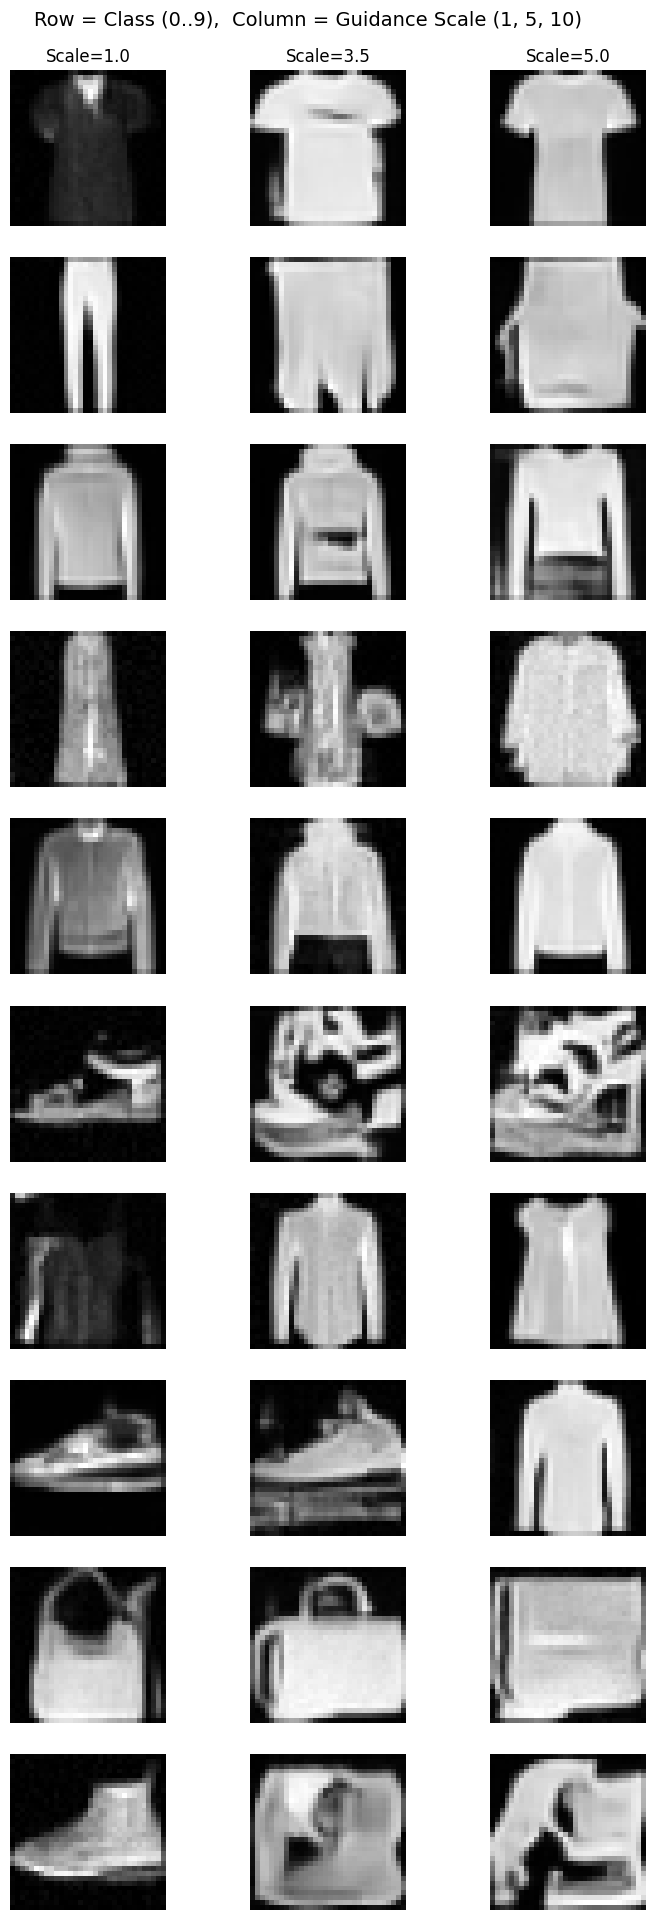

In [ ]:
############################################################
# 10. Демонстрация генерации
############################################################
import matplotlib.pyplot as plt

guidance_scales = [1.0, 3.5, 5.0]
num_classes = 10
num_inference_steps = 5

fig, axs = plt.subplots(
    nrows=num_classes,
    ncols=len(guidance_scales),
    figsize=(8, 20)  # подбирайте под свой вкус
)

model.eval()

for class_idx in range(num_classes):
    for scale_idx, guidance_scale in enumerate(guidance_scales):
        gen_img = generate_image(
            model,
            scheduler,
            class_label=class_idx,
            guidance_scale=guidance_scale,
            num_inference_steps=num_inference_steps
        )

        img_np = gen_img.squeeze(0).squeeze(0).detach().cpu().numpy()

        axs[class_idx, scale_idx].imshow(img_np, cmap="gray")
        axs[class_idx, scale_idx].axis("off")

        if class_idx == 0:
            axs[class_idx, scale_idx].set_title(f"Scale={guidance_scale}", fontsize=12)

        if scale_idx == 0:
            axs[class_idx, scale_idx].set_ylabel(f"Class {class_idx}", rotation=90, labelpad=10, fontsize=12)

fig.suptitle("Row = Class (0..9))", fontsize=14)

plt.subplots_adjust(top=0.95, bottom=0.03, left=0.1, right=0.95, wspace=0.2, hspace=0.2)

plt.show()
